# Matrix Factorization with SimEc
In this notebook are some examples to show that SimEc can be used to compute the SVD or eigendecomposition of a matrix.

Performing an SVD and eigendecomposition of a matrix with neural networks was first described by A. Cichocki (et al.) in 1992 in [this paper (SVD)](http://ieeexplore.ieee.org/document/133134/?reload=true) and [this paper (eigendecomposition)](https://link.springer.com/article/10.1007/BF00201437).

In [1]:
import numpy as np
np.random.seed(28)
import matplotlib.pyplot as plt
import tensorflow as tf
tf.set_random_seed(28)
import keras

from simec import SimilarityEncoder

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
def msqe(A, B):
    # compute the mean squared error between two matrices A and B
    # obviously, A and B should be the same shape...
    return np.mean((A - B) ** 2)

In [3]:
# generate a random matrix
n_input = 500
n_output = 700
A = np.random.rand(n_input, n_output)
# compute its SVD
U, s, Vh = np.linalg.svd(A, full_matrices=True)
U.shape, s.shape, Vh.shape

((500, 500), (500,), (700, 700))

In [4]:
# make the eigenvalues of A a bit more extreme
S = np.zeros((n_input, n_output))
s[0] = s[1]+1
s[:10] *= 50.
s[10:20] *= 20.
s[20:100] *= 10.
S[:n_input, :n_input] = np.diag(s)
# recompute A and scale it to be in a somewhat reasonable range
A = np.dot(U, np.dot(S, Vh))
A = A/np.max(np.abs(A))
# recompute SVD again
U, s, Vh = np.linalg.svd(A, full_matrices=True)
S = np.zeros((n_input, n_output))
S[:n_input, :n_input] = np.diag(s)

In [5]:
# check that eigenvectors are orthogonal
np.dot(Vh[:100,:], Vh[:100,:].T)

array([[  1.00000000e+00,  -5.45570533e-16,   1.30971622e-16, ...,
          6.93889390e-17,   1.25767452e-17,  -1.38777878e-17],
       [ -5.45570533e-16,   1.00000000e+00,   2.48065457e-16, ...,
         -5.20417043e-17,  -9.19403442e-17,  -2.94902991e-17],
       [  1.30971622e-16,   2.48065457e-16,   1.00000000e+00, ...,
          3.46944695e-18,   7.97972799e-17,   8.58688121e-17],
       ..., 
       [  6.93889390e-17,  -5.20417043e-17,   3.46944695e-18, ...,
          1.00000000e+00,  -1.04083409e-15,   3.79904441e-16],
       [  1.25767452e-17,  -9.19403442e-17,   7.97972799e-17, ...,
         -1.04083409e-15,   1.00000000e+00,  -2.30067701e-16],
       [ -1.38777878e-17,  -2.94902991e-17,   8.58688121e-17, ...,
          3.79904441e-16,  -2.30067701e-16,   1.00000000e+00]])

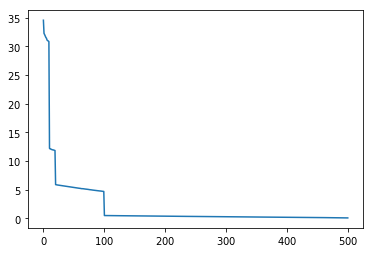

In [6]:
# inspect eigenvalues
plt.plot(s)

### SVD of a random matrix

In [7]:
# mean squared error of approximation decreases with more embedding dim
for e_dim in [2, 10, 25, 50, 75, 100, 250, 400, 500]:
    print "mse with %3i e_dim: %.8f" % (e_dim, msqe(A, np.dot(U[:,:e_dim], np.dot(S[:e_dim,:e_dim], Vh[:e_dim,:]))))

mse with   2 e_dim: 0.03285552
mse with  10 e_dim: 0.01045687
mse with  25 e_dim: 0.00588207
mse with  50 e_dim: 0.00367207
mse with  75 e_dim: 0.00175594
mse with 100 e_dim: 0.00009198
mse with 250 e_dim: 0.00002807
mse with 400 e_dim: 0.00000396
mse with 500 e_dim: 0.00000000


In [8]:
# factorize the matrix with a simec
X = np.eye(n_input)
mses = []
e_dims =  [2, 10, 25, 50, 75, 100, 250, 400, 500, 750, 1000]
l_rates = {400: 0.004, 500: 0.0034, 750: 0.0032, 1000: 0.003}
for e_dim in e_dims:
    model = SimilarityEncoder(n_input, e_dim, n_output, opt=keras.optimizers.Adamax(lr=0.005 if e_dim <= 250 else l_rates[e_dim]))
    model.fit(X, A, epochs=50)
    mse = msqe(A, model.predict(X))
    mses.append(mse)
    print "mse with %4i e_dim: %.8f" % (e_dim, mse)
for i, e_dim in enumerate(e_dims):
    print "mse with %4i e_dim: %.8f" % (e_dim, mses[i])

Epoch 1/50
500/500 [==============================] - 1s 1ms/step - loss: 0.0392
Epoch 2/50
500/500 [==============================] - 0s 91us/step - loss: 0.0388
Epoch 3/50
500/500 [==============================] - 0s 92us/step - loss: 0.0377
Epoch 4/50
500/500 [==============================] - 0s 78us/step - loss: 0.0365
Epoch 5/50
500/500 [==============================] - 0s 92us/step - loss: 0.0360
Epoch 6/50
500/500 [==============================] - 0s 85us/step - loss: 0.0359
Epoch 7/50
500/500 [==============================] - 0s 84us/step - loss: 0.0359
Epoch 8/50
500/500 [==============================] - 0s 80us/step - loss: 0.0358
Epoch 9/50
500/500 [==============================] - 0s 82us/step - loss: 0.0358
Epoch 10/50
500/500 [==============================] - 0s 87us/step - loss: 0.0358
Epoch 11/50
500/500 [==============================] - 0s 84us/step - loss: 0.0358
Epoch 12/50
500/500 [==============================] - 0s 70us/step - loss: 0.0357
Epoch 13/50
50

500/500 [==============================] - 0s 74us/step - loss: 0.0118
Epoch 50/50
500/500 [==============================] - 0s 73us/step - loss: 0.0117
mse with   10 e_dim: 0.01103354
Epoch 1/50
500/500 [==============================] - 0s 214us/step - loss: 0.0392
Epoch 2/50
500/500 [==============================] - 0s 71us/step - loss: 0.0366
Epoch 3/50
500/500 [==============================] - 0s 94us/step - loss: 0.0358
Epoch 4/50
500/500 [==============================] - 0s 85us/step - loss: 0.0354
Epoch 5/50
500/500 [==============================] - 0s 81us/step - loss: 0.0350
Epoch 6/50
500/500 [==============================] - 0s 76us/step - loss: 0.0344
Epoch 7/50
500/500 [==============================] - 0s 81us/step - loss: 0.0337
Epoch 8/50
500/500 [==============================] - 0s 78us/step - loss: 0.0327
Epoch 9/50
500/500 [==============================] - 0s 85us/step - loss: 0.0316
Epoch 10/50
500/500 [==============================] - 0s 76us/step - loss:

500/500 [==============================] - 0s 77us/step - loss: 0.0061
Epoch 48/50
500/500 [==============================] - 0s 76us/step - loss: 0.0060
Epoch 49/50
500/500 [==============================] - 0s 75us/step - loss: 0.0059
Epoch 50/50
500/500 [==============================] - 0s 68us/step - loss: 0.0059
mse with   50 e_dim: 0.00471622
Epoch 1/50
500/500 [==============================] - 0s 283us/step - loss: 0.0395
Epoch 2/50
500/500 [==============================] - 0s 78us/step - loss: 0.0361
Epoch 3/50
500/500 [==============================] - 0s 94us/step - loss: 0.0353
Epoch 4/50
500/500 [==============================] - 0s 90us/step - loss: 0.0341
Epoch 5/50
500/500 [==============================] - 0s 88us/step - loss: 0.0326
Epoch 6/50
500/500 [==============================] - 0s 88us/step - loss: 0.0305
Epoch 7/50
500/500 [==============================] - 0s 88us/step - loss: 0.0280
Epoch 8/50
500/500 [==============================] - 0s 93us/step - loss

500/500 [==============================] - 0s 83us/step - loss: 0.0034
Epoch 46/50
500/500 [==============================] - 0s 81us/step - loss: 0.0033
Epoch 47/50
500/500 [==============================] - 0s 80us/step - loss: 0.0031
Epoch 48/50
500/500 [==============================] - 0s 100us/step - loss: 0.0030
Epoch 49/50
500/500 [==============================] - 0s 83us/step - loss: 0.0029
Epoch 50/50
500/500 [==============================] - 0s 83us/step - loss: 0.0028
mse with  100 e_dim: 0.00131175
Epoch 1/50
500/500 [==============================] - 0s 319us/step - loss: 0.0402
Epoch 2/50
500/500 [==============================] - 0s 72us/step - loss: 0.0357
Epoch 3/50
500/500 [==============================] - 0s 84us/step - loss: 0.0330
Epoch 4/50
500/500 [==============================] - 0s 81us/step - loss: 0.0293
Epoch 5/50
500/500 [==============================] - 0s 78us/step - loss: 0.0244
Epoch 6/50
500/500 [==============================] - 0s 85us/step - l

500/500 [==============================] - 0s 83us/step - loss: 0.0019
Epoch 44/50
500/500 [==============================] - 0s 81us/step - loss: 0.0019
Epoch 45/50
500/500 [==============================] - 0s 84us/step - loss: 0.0018
Epoch 46/50
500/500 [==============================] - 0s 98us/step - loss: 0.0018
Epoch 47/50
500/500 [==============================] - 0s 89us/step - loss: 0.0018
Epoch 48/50
500/500 [==============================] - 0s 95us/step - loss: 0.0018
Epoch 49/50
500/500 [==============================] - 0s 89us/step - loss: 0.0017
Epoch 50/50
500/500 [==============================] - 0s 93us/step - loss: 0.0017
mse with  400 e_dim: 0.00018721
Epoch 1/50
500/500 [==============================] - 0s 383us/step - loss: 0.0418
Epoch 2/50
500/500 [==============================] - 0s 88us/step - loss: 0.0362
Epoch 3/50
500/500 [==============================] - 0s 98us/step - loss: 0.0333
Epoch 4/50
500/500 [==============================] - 0s 101us/step -

500/500 [==============================] - 0s 120us/step - loss: 0.0021
Epoch 41/50
500/500 [==============================] - 0s 122us/step - loss: 0.0020
Epoch 42/50
500/500 [==============================] - 0s 121us/step - loss: 0.0020
Epoch 43/50
500/500 [==============================] - 0s 100us/step - loss: 0.0020
Epoch 44/50
500/500 [==============================] - 0s 99us/step - loss: 0.0019
Epoch 45/50
500/500 [==============================] - 0s 96us/step - loss: 0.0019
Epoch 46/50
500/500 [==============================] - 0s 105us/step - loss: 0.0019
Epoch 47/50
500/500 [==============================] - 0s 106us/step - loss: 0.0018
Epoch 48/50
500/500 [==============================] - 0s 93us/step - loss: 0.0018
Epoch 49/50
500/500 [==============================] - 0s 110us/step - loss: 0.0018
Epoch 50/50
500/500 [==============================] - 0s 101us/step - loss: 0.0018
mse with  750 e_dim: 0.00016948
Epoch 1/50
500/500 [==============================] - 0s 49

In [9]:
# factorize the matrix with a simec - transpose works just as well
# this time we use the embedding we learned before as the weights of the last layer
# to get the mapping function for the other side of the equation (which is of course kind of useless
# here since we don't actually map feature vectors but only identiy vectors)
X1 = np.eye(n_input)
X2 = np.eye(n_output)
mses1 = []
mses2 = []
mses3 = []
e_dims =  [2, 10, 25, 50, 75, 100, 250, 400, 500, 750, 1000]
for e_dim in e_dims:
    model = SimilarityEncoder(n_input, e_dim, n_output, opt=keras.optimizers.Adamax(lr=0.005 if e_dim <= 250 else l_rates[e_dim]))
    model.fit(X1, A, epochs=50)
    mse = msqe(A, model.predict(X1))
    mses1.append(mse)
    print "mse with %4i e_dim: %.8f" % (e_dim, mse)
    Y1 = model.transform(X1)
    model = SimilarityEncoder(n_output, e_dim, n_input, W_ll=Y1.T, opt=keras.optimizers.Adamax(lr=0.005 if e_dim <= 250 else l_rates[e_dim]))
    model.fit(X2, A.T, epochs=50)
    mse = msqe(A.T, model.predict(X2))
    mses2.append(mse)
    print "mse with %4i e_dim: %.8f" % (e_dim, mse)
    Y2 = model.transform(X2)
    # the dot product of both embeddings should also approximate A
    mse = msqe(A, np.dot(Y1, Y2.T))
    mses3.append(mse)
for i, e_dim in enumerate(e_dims):
    print "mse with %4i e_dim: %.8f / %.8f / %.8f" % (e_dim, mses1[i], mses2[i], mses3[i])

Epoch 1/50
500/500 [==============================] - 0s 416us/step - loss: 0.0392
Epoch 2/50
500/500 [==============================] - 0s 68us/step - loss: 0.0388
Epoch 3/50
500/500 [==============================] - 0s 83us/step - loss: 0.0377
Epoch 4/50
500/500 [==============================] - 0s 70us/step - loss: 0.0365
Epoch 5/50
500/500 [==============================] - 0s 74us/step - loss: 0.0360
Epoch 6/50
500/500 [==============================] - 0s 69us/step - loss: 0.0359
Epoch 7/50
500/500 [==============================] - 0s 74us/step - loss: 0.0359
Epoch 8/50
500/500 [==============================] - 0s 81us/step - loss: 0.0358
Epoch 9/50
500/500 [==============================] - 0s 83us/step - loss: 0.0358
Epoch 10/50
500/500 [==============================] - 0s 93us/step - loss: 0.0358
Epoch 11/50
500/500 [==============================] - 0s 71us/step - loss: 0.0358
Epoch 12/50
500/500 [==============================] - 0s 94us/step - loss: 0.0358
Epoch 13/50


700/700 [==============================] - 0s 77us/step - loss: 0.0341
Epoch 50/50
700/700 [==============================] - 0s 86us/step - loss: 0.0341
mse with    2 e_dim: 0.03387340
Epoch 1/50
500/500 [==============================] - 0s 456us/step - loss: 0.0393
Epoch 2/50
500/500 [==============================] - 0s 82us/step - loss: 0.0377
Epoch 3/50
500/500 [==============================] - 0s 77us/step - loss: 0.0361
Epoch 4/50
500/500 [==============================] - 0s 88us/step - loss: 0.0358
Epoch 5/50
500/500 [==============================] - 0s 87us/step - loss: 0.0357
Epoch 6/50
500/500 [==============================] - 0s 74us/step - loss: 0.0355
Epoch 7/50
500/500 [==============================] - 0s 86us/step - loss: 0.0354
Epoch 8/50
500/500 [==============================] - 0s 79us/step - loss: 0.0351
Epoch 9/50
500/500 [==============================] - 0s 84us/step - loss: 0.0349
Epoch 10/50
500/500 [==============================] - 0s 62us/step - loss:

700/700 [==============================] - 0s 77us/step - loss: 0.0245
Epoch 48/50
700/700 [==============================] - 0s 81us/step - loss: 0.0243
Epoch 49/50
700/700 [==============================] - 0s 93us/step - loss: 0.0242
Epoch 50/50
700/700 [==============================] - 0s 74us/step - loss: 0.0241
mse with   10 e_dim: 0.02230964
Epoch 1/50
500/500 [==============================] - 0s 495us/step - loss: 0.0394
Epoch 2/50
500/500 [==============================] - 0s 67us/step - loss: 0.0368
Epoch 3/50
500/500 [==============================] - 0s 80us/step - loss: 0.0358
Epoch 4/50
500/500 [==============================] - 0s 86us/step - loss: 0.0355
Epoch 5/50
500/500 [==============================] - 0s 80us/step - loss: 0.0351
Epoch 6/50
500/500 [==============================] - 0s 73us/step - loss: 0.0345
Epoch 7/50
500/500 [==============================] - 0s 93us/step - loss: 0.0338
Epoch 8/50
500/500 [==============================] - 0s 83us/step - loss

700/700 [==============================] - 0s 73us/step - loss: 0.0214
Epoch 46/50
700/700 [==============================] - 0s 84us/step - loss: 0.0213
Epoch 47/50
700/700 [==============================] - 0s 86us/step - loss: 0.0211
Epoch 48/50
700/700 [==============================] - 0s 90us/step - loss: 0.0210
Epoch 49/50
700/700 [==============================] - 0s 83us/step - loss: 0.0209
Epoch 50/50
700/700 [==============================] - 0s 90us/step - loss: 0.0208
mse with   25 e_dim: 0.01744425
Epoch 1/50
500/500 [==============================] - 0s 561us/step - loss: 0.0395
Epoch 2/50
500/500 [==============================] - 0s 90us/step - loss: 0.0364
Epoch 3/50
500/500 [==============================] - 0s 73us/step - loss: 0.0355
Epoch 4/50
500/500 [==============================] - 0s 82us/step - loss: 0.0349
Epoch 5/50
500/500 [==============================] - 0s 86us/step - loss: 0.0339
Epoch 6/50
500/500 [==============================] - 0s 81us/step - lo

700/700 [==============================] - 0s 72us/step - loss: 0.0200
Epoch 44/50
700/700 [==============================] - 0s 71us/step - loss: 0.0199
Epoch 45/50
700/700 [==============================] - 0s 72us/step - loss: 0.0198
Epoch 46/50
700/700 [==============================] - 0s 78us/step - loss: 0.0197
Epoch 47/50
700/700 [==============================] - 0s 99us/step - loss: 0.0196
Epoch 48/50
700/700 [==============================] - 0s 70us/step - loss: 0.0195
Epoch 49/50
700/700 [==============================] - 0s 83us/step - loss: 0.0194
Epoch 50/50
700/700 [==============================] - 0s 80us/step - loss: 0.0194
mse with   50 e_dim: 0.01451222
Epoch 1/50
500/500 [==============================] - 0s 586us/step - loss: 0.0396
Epoch 2/50
500/500 [==============================] - 0s 72us/step - loss: 0.0362
Epoch 3/50
500/500 [==============================] - 0s 85us/step - loss: 0.0353
Epoch 4/50
500/500 [==============================] - 0s 72us/step - 

700/700 [==============================] - 0s 67us/step - loss: 0.0194
Epoch 42/50
700/700 [==============================] - 0s 76us/step - loss: 0.0193
Epoch 43/50
700/700 [==============================] - 0s 77us/step - loss: 0.0192
Epoch 44/50
700/700 [==============================] - 0s 77us/step - loss: 0.0191
Epoch 45/50
700/700 [==============================] - 0s 83us/step - loss: 0.0190
Epoch 46/50
700/700 [==============================] - 0s 77us/step - loss: 0.0190
Epoch 47/50
700/700 [==============================] - 0s 84us/step - loss: 0.0189
Epoch 48/50
700/700 [==============================] - 0s 78us/step - loss: 0.0188
Epoch 49/50
700/700 [==============================] - 0s 97us/step - loss: 0.0188
Epoch 50/50
700/700 [==============================] - 0s 76us/step - loss: 0.0187
mse with   75 e_dim: 0.01294187
Epoch 1/50
500/500 [==============================] - 0s 667us/step - loss: 0.0397
Epoch 2/50
500/500 [==============================] - 0s 106us/step

700/700 [==============================] - 0s 80us/step - loss: 0.0190
Epoch 40/50
700/700 [==============================] - 0s 84us/step - loss: 0.0190
Epoch 41/50
700/700 [==============================] - 0s 94us/step - loss: 0.0189
Epoch 42/50
700/700 [==============================] - 0s 86us/step - loss: 0.0188
Epoch 43/50
700/700 [==============================] - 0s 76us/step - loss: 0.0187
Epoch 44/50
700/700 [==============================] - 0s 77us/step - loss: 0.0187
Epoch 45/50
700/700 [==============================] - 0s 88us/step - loss: 0.0186
Epoch 46/50
700/700 [==============================] - 0s 91us/step - loss: 0.0185
Epoch 47/50
700/700 [==============================] - 0s 91us/step - loss: 0.0185
Epoch 48/50
700/700 [==============================] - 0s 75us/step - loss: 0.0185
Epoch 49/50
700/700 [==============================] - 0s 84us/step - loss: 0.0184
Epoch 50/50
700/700 [==============================] - 0s 80us/step - loss: 0.0184
mse with  100 e_

700/700 [==============================] - 0s 81us/step - loss: 0.0188
Epoch 38/50
700/700 [==============================] - 0s 74us/step - loss: 0.0188
Epoch 39/50
700/700 [==============================] - 0s 70us/step - loss: 0.0187
Epoch 40/50
700/700 [==============================] - 0s 75us/step - loss: 0.0187
Epoch 41/50
700/700 [==============================] - 0s 94us/step - loss: 0.0186
Epoch 42/50
700/700 [==============================] - 0s 89us/step - loss: 0.0186
Epoch 43/50
700/700 [==============================] - 0s 87us/step - loss: 0.0186
Epoch 44/50
700/700 [==============================] - 0s 81us/step - loss: 0.0186
Epoch 45/50
700/700 [==============================] - 0s 91us/step - loss: 0.0185
Epoch 46/50
700/700 [==============================] - 0s 83us/step - loss: 0.0185
Epoch 47/50
700/700 [==============================] - 0s 83us/step - loss: 0.0185
Epoch 48/50
700/700 [==============================] - 0s 77us/step - loss: 0.0185
Epoch 49/50
700/

700/700 [==============================] - 0s 97us/step - loss: 0.0184
Epoch 36/50
700/700 [==============================] - 0s 79us/step - loss: 0.0183
Epoch 37/50
700/700 [==============================] - 0s 87us/step - loss: 0.0183
Epoch 38/50
700/700 [==============================] - 0s 99us/step - loss: 0.0182
Epoch 39/50
700/700 [==============================] - 0s 88us/step - loss: 0.0182
Epoch 40/50
700/700 [==============================] - 0s 97us/step - loss: 0.0181
Epoch 41/50
700/700 [==============================] - 0s 78us/step - loss: 0.0181
Epoch 42/50
700/700 [==============================] - 0s 81us/step - loss: 0.0181
Epoch 43/50
700/700 [==============================] - 0s 88us/step - loss: 0.0180
Epoch 44/50
700/700 [==============================] - 0s 79us/step - loss: 0.0180
Epoch 45/50
700/700 [==============================] - 0s 105us/step - loss: 0.0180
Epoch 46/50
700/700 [==============================] - 0s 91us/step - loss: 0.0180
Epoch 47/50
700

700/700 [==============================] - 0s 87us/step - loss: 0.0184
Epoch 33/50
700/700 [==============================] - 0s 90us/step - loss: 0.0183
Epoch 34/50
700/700 [==============================] - 0s 92us/step - loss: 0.0183
Epoch 35/50
700/700 [==============================] - 0s 85us/step - loss: 0.0182
Epoch 36/50
700/700 [==============================] - 0s 93us/step - loss: 0.0181
Epoch 37/50
700/700 [==============================] - 0s 92us/step - loss: 0.0181
Epoch 38/50
700/700 [==============================] - 0s 93us/step - loss: 0.0180
Epoch 39/50
700/700 [==============================] - 0s 80us/step - loss: 0.0179
Epoch 40/50
700/700 [==============================] - 0s 99us/step - loss: 0.0179
Epoch 41/50
700/700 [==============================] - 0s 112us/step - loss: 0.0179
Epoch 42/50
700/700 [==============================] - 0s 98us/step - loss: 0.0178
Epoch 43/50
700/700 [==============================] - 0s 92us/step - loss: 0.0178
Epoch 44/50
700

700/700 [==============================] - 0s 81us/step - loss: 0.0187
Epoch 30/50
700/700 [==============================] - 0s 90us/step - loss: 0.0186
Epoch 31/50
700/700 [==============================] - 0s 93us/step - loss: 0.0186
Epoch 32/50
700/700 [==============================] - 0s 77us/step - loss: 0.0185
Epoch 33/50
700/700 [==============================] - 0s 93us/step - loss: 0.0184
Epoch 34/50
700/700 [==============================] - 0s 89us/step - loss: 0.0183
Epoch 35/50
700/700 [==============================] - 0s 79us/step - loss: 0.0183
Epoch 36/50
700/700 [==============================] - 0s 102us/step - loss: 0.0182
Epoch 37/50
700/700 [==============================] - 0s 96us/step - loss: 0.0182
Epoch 38/50
700/700 [==============================] - 0s 93us/step - loss: 0.0181
Epoch 39/50
700/700 [==============================] - 0s 85us/step - loss: 0.0181
Epoch 40/50
700/700 [==============================] - 0s 91us/step - loss: 0.0181
Epoch 41/50
700

700/700 [==============================] - 0s 94us/step - loss: 0.0191
Epoch 27/50
700/700 [==============================] - 0s 85us/step - loss: 0.0190
Epoch 28/50
700/700 [==============================] - 0s 100us/step - loss: 0.0189
Epoch 29/50
700/700 [==============================] - 0s 105us/step - loss: 0.0188
Epoch 30/50
700/700 [==============================] - 0s 108us/step - loss: 0.0187
Epoch 31/50
700/700 [==============================] - 0s 106us/step - loss: 0.0186
Epoch 32/50
700/700 [==============================] - 0s 113us/step - loss: 0.0185
Epoch 33/50
700/700 [==============================] - 0s 113us/step - loss: 0.0185
Epoch 34/50
700/700 [==============================] - 0s 112us/step - loss: 0.0184
Epoch 35/50
700/700 [==============================] - 0s 104us/step - loss: 0.0183
Epoch 36/50
700/700 [==============================] - 0s 112us/step - loss: 0.0183
Epoch 37/50
700/700 [==============================] - 0s 121us/step - loss: 0.0183
Epoch 

#### Dealing with missing values
A regular SVD can not be computed for a matrix with missing values, therefore these need to be filled by some values, e.g. the average of the matrix. SimEc on the other hand can compute the backpropagation error considering only the available entries of the matrix, which means it can easily handle about 50% missing values without seeing major performance decreases and consistently outperforms the regular SVD (results would probably be even better with more careful hyperparameter tuning, e.g. using some regularization).

0.0
Epoch 1/60
500/500 [==============================] - 0s 951us/step - loss: 0.0378
Epoch 2/60
500/500 [==============================] - 0s 76us/step - loss: 0.0361
Epoch 3/60
500/500 [==============================] - 0s 78us/step - loss: 0.0360
Epoch 4/60
500/500 [==============================] - 0s 99us/step - loss: 0.0358
Epoch 5/60
500/500 [==============================] - 0s 98us/step - loss: 0.0357
Epoch 6/60
500/500 [==============================] - 0s 92us/step - loss: 0.0355
Epoch 7/60
500/500 [==============================] - 0s 90us/step - loss: 0.0350
Epoch 8/60
500/500 [==============================] - 0s 98us/step - loss: 0.0345
Epoch 9/60
500/500 [==============================] - 0s 101us/step - loss: 0.0339
Epoch 10/60
500/500 [==============================] - 0s 102us/step - loss: 0.0336
Epoch 11/60
500/500 [==============================] - 0s 104us/step - loss: 0.0334
Epoch 12/60
500/500 [==============================] - 0s 104us/step - loss: 0.0333
Epoc

500/500 [==============================] - 0s 78us/step - loss: 0.0331
Epoch 40/60
500/500 [==============================] - 0s 86us/step - loss: 0.0331
Epoch 41/60
500/500 [==============================] - 0s 109us/step - loss: 0.0331
Epoch 42/60
500/500 [==============================] - 0s 76us/step - loss: 0.0331
Epoch 43/60
500/500 [==============================] - 0s 98us/step - loss: 0.0331
Epoch 44/60
500/500 [==============================] - 0s 93us/step - loss: 0.0331
Epoch 45/60
500/500 [==============================] - 0s 92us/step - loss: 0.0331
Epoch 46/60
500/500 [==============================] - 0s 87us/step - loss: 0.0331
Epoch 47/60
500/500 [==============================] - 0s 77us/step - loss: 0.0331
Epoch 48/60
500/500 [==============================] - 0s 95us/step - loss: 0.0331
Epoch 49/60
500/500 [==============================] - 0s 89us/step - loss: 0.0331
Epoch 50/60
500/500 [==============================] - 0s 81us/step - loss: 0.0331
Epoch 51/60
500

500/500 [==============================] - 0s 93us/step - loss: 0.0328
Epoch 18/60
500/500 [==============================] - 0s 98us/step - loss: 0.0328
Epoch 19/60
500/500 [==============================] - 0s 82us/step - loss: 0.0328
Epoch 20/60
500/500 [==============================] - 0s 84us/step - loss: 0.0328
Epoch 21/60
500/500 [==============================] - 0s 88us/step - loss: 0.0328
Epoch 22/60
500/500 [==============================] - 0s 101us/step - loss: 0.0328
Epoch 23/60
500/500 [==============================] - 0s 103us/step - loss: 0.0328
Epoch 24/60
500/500 [==============================] - 0s 103us/step - loss: 0.0328
Epoch 25/60
500/500 [==============================] - 0s 86us/step - loss: 0.0328
Epoch 26/60
500/500 [==============================] - 0s 76us/step - loss: 0.0328
Epoch 27/60
500/500 [==============================] - 0s 110us/step - loss: 0.0328
Epoch 28/60
500/500 [==============================] - 0s 96us/step - loss: 0.0328
Epoch 29/60


500/500 [==============================] - 0s 88us/step - loss: 0.0328
Epoch 56/60
500/500 [==============================] - 0s 83us/step - loss: 0.0328
Epoch 57/60
500/500 [==============================] - 0s 90us/step - loss: 0.0328
Epoch 58/60
500/500 [==============================] - 0s 95us/step - loss: 0.0328
Epoch 59/60
500/500 [==============================] - 0s 92us/step - loss: 0.0328
Epoch 60/60
500/500 [==============================] - 0s 97us/step - loss: 0.0328
0.5
Epoch 1/60
500/500 [==============================] - 1s 1ms/step - loss: 0.0391
Epoch 2/60
500/500 [==============================] - 0s 83us/step - loss: 0.0365
Epoch 3/60
500/500 [==============================] - 0s 92us/step - loss: 0.0359
Epoch 4/60
500/500 [==============================] - 0s 97us/step - loss: 0.0358
Epoch 5/60
500/500 [==============================] - 0s 86us/step - loss: 0.0355
Epoch 6/60
500/500 [==============================] - 0s 86us/step - loss: 0.0352
Epoch 7/60
500/500 

500/500 [==============================] - 0s 84us/step - loss: 0.0329
Epoch 34/60
500/500 [==============================] - 0s 85us/step - loss: 0.0329
Epoch 35/60
500/500 [==============================] - 0s 100us/step - loss: 0.0329
Epoch 36/60
500/500 [==============================] - 0s 96us/step - loss: 0.0329
Epoch 37/60
500/500 [==============================] - 0s 83us/step - loss: 0.0329
Epoch 38/60
500/500 [==============================] - 0s 88us/step - loss: 0.0329
Epoch 39/60
500/500 [==============================] - 0s 95us/step - loss: 0.0329
Epoch 40/60
500/500 [==============================] - 0s 96us/step - loss: 0.0329
Epoch 41/60
500/500 [==============================] - 0s 90us/step - loss: 0.0329
Epoch 42/60
500/500 [==============================] - 0s 91us/step - loss: 0.0329
Epoch 43/60
500/500 [==============================] - 0s 89us/step - loss: 0.0329
Epoch 44/60
500/500 [==============================] - 0s 83us/step - loss: 0.0329
Epoch 45/60
500

500/500 [==============================] - 0s 87us/step - loss: 0.0346
Epoch 12/60
500/500 [==============================] - 0s 88us/step - loss: 0.0343
Epoch 13/60
500/500 [==============================] - 0s 88us/step - loss: 0.0340
Epoch 14/60
500/500 [==============================] - 0s 95us/step - loss: 0.0338
Epoch 15/60
500/500 [==============================] - 0s 97us/step - loss: 0.0335
Epoch 16/60
500/500 [==============================] - 0s 98us/step - loss: 0.0334
Epoch 17/60
500/500 [==============================] - 0s 93us/step - loss: 0.0332
Epoch 18/60
500/500 [==============================] - 0s 105us/step - loss: 0.0331
Epoch 19/60
500/500 [==============================] - 0s 87us/step - loss: 0.0331
Epoch 20/60
500/500 [==============================] - 0s 95us/step - loss: 0.0330
Epoch 21/60
500/500 [==============================] - 0s 96us/step - loss: 0.0329
Epoch 22/60
500/500 [==============================] - 0s 89us/step - loss: 0.0329
Epoch 23/60
500

500/500 [==============================] - 0s 89us/step - loss: 0.0319
Epoch 50/60
500/500 [==============================] - 0s 81us/step - loss: 0.0318
Epoch 51/60
500/500 [==============================] - 0s 90us/step - loss: 0.0318
Epoch 52/60
500/500 [==============================] - 0s 132us/step - loss: 0.0318
Epoch 53/60
500/500 [==============================] - 0s 95us/step - loss: 0.0318
Epoch 54/60
500/500 [==============================] - 0s 97us/step - loss: 0.0318
Epoch 55/60
500/500 [==============================] - 0s 95us/step - loss: 0.0318
Epoch 56/60
500/500 [==============================] - 0s 106us/step - loss: 0.0318
Epoch 57/60
500/500 [==============================] - 0s 98us/step - loss: 0.0318
Epoch 58/60
500/500 [==============================] - 0s 91us/step - loss: 0.0318
Epoch 59/60
500/500 [==============================] - 0s 115us/step - loss: 0.0318
Epoch 60/60
500/500 [==============================] - 0s 91us/step - loss: 0.0318
[0.0330129268

500/500 [==============================] - 0s 98us/step - loss: 0.0110
Epoch 26/60
500/500 [==============================] - 0s 99us/step - loss: 0.0110
Epoch 27/60
500/500 [==============================] - 0s 99us/step - loss: 0.0110
Epoch 28/60
500/500 [==============================] - 0s 108us/step - loss: 0.0110
Epoch 29/60
500/500 [==============================] - 0s 92us/step - loss: 0.0110
Epoch 30/60
500/500 [==============================] - 0s 97us/step - loss: 0.0110
Epoch 31/60
500/500 [==============================] - 0s 86us/step - loss: 0.0110
Epoch 32/60
500/500 [==============================] - 0s 104us/step - loss: 0.0110
Epoch 33/60
500/500 [==============================] - 0s 101us/step - loss: 0.0110
Epoch 34/60
500/500 [==============================] - 0s 88us/step - loss: 0.0109
Epoch 35/60
500/500 [==============================] - 0s 85us/step - loss: 0.0110
Epoch 36/60
500/500 [==============================] - 0s 89us/step - loss: 0.0109
Epoch 37/60
5

500/500 [==============================] - 0s 94us/step - loss: 0.0337
Epoch 4/60
500/500 [==============================] - 0s 84us/step - loss: 0.0307
Epoch 5/60
500/500 [==============================] - 0s 93us/step - loss: 0.0270
Epoch 6/60
500/500 [==============================] - 0s 96us/step - loss: 0.0232
Epoch 7/60
500/500 [==============================] - 0s 83us/step - loss: 0.0198
Epoch 8/60
500/500 [==============================] - 0s 114us/step - loss: 0.0172
Epoch 9/60
500/500 [==============================] - 0s 86us/step - loss: 0.0154
Epoch 10/60
500/500 [==============================] - 0s 83us/step - loss: 0.0144
Epoch 11/60
500/500 [==============================] - 0s 95us/step - loss: 0.0139
Epoch 12/60
500/500 [==============================] - 0s 89us/step - loss: 0.0135
Epoch 13/60
500/500 [==============================] - 0s 88us/step - loss: 0.0130
Epoch 14/60
500/500 [==============================] - 0s 72us/step - loss: 0.0123
Epoch 15/60
500/500 [

500/500 [==============================] - 0s 102us/step - loss: 0.0108
Epoch 42/60
500/500 [==============================] - 0s 107us/step - loss: 0.0108
Epoch 43/60
500/500 [==============================] - 0s 105us/step - loss: 0.0108
Epoch 44/60
500/500 [==============================] - 0s 83us/step - loss: 0.0108
Epoch 45/60
500/500 [==============================] - 0s 102us/step - loss: 0.0108
Epoch 46/60
500/500 [==============================] - 0s 93us/step - loss: 0.0108
Epoch 47/60
500/500 [==============================] - 0s 77us/step - loss: 0.0108
Epoch 48/60
500/500 [==============================] - 0s 84us/step - loss: 0.0108
Epoch 49/60
500/500 [==============================] - 0s 88us/step - loss: 0.0107
Epoch 50/60
500/500 [==============================] - 0s 98us/step - loss: 0.0108
Epoch 51/60
500/500 [==============================] - 0s 93us/step - loss: 0.0107
Epoch 52/60
500/500 [==============================] - 0s 91us/step - loss: 0.0107
Epoch 53/60


500/500 [==============================] - 0s 90us/step - loss: 0.0107
Epoch 20/60
500/500 [==============================] - 0s 93us/step - loss: 0.0107
Epoch 21/60
500/500 [==============================] - 0s 85us/step - loss: 0.0107
Epoch 22/60
500/500 [==============================] - 0s 90us/step - loss: 0.0107
Epoch 23/60
500/500 [==============================] - 0s 78us/step - loss: 0.0107
Epoch 24/60
500/500 [==============================] - 0s 89us/step - loss: 0.0107
Epoch 25/60
500/500 [==============================] - 0s 95us/step - loss: 0.0106
Epoch 26/60
500/500 [==============================] - 0s 92us/step - loss: 0.0106
Epoch 27/60
500/500 [==============================] - 0s 89us/step - loss: 0.0106
Epoch 28/60
500/500 [==============================] - 0s 81us/step - loss: 0.0106
Epoch 29/60
500/500 [==============================] - 0s 84us/step - loss: 0.0106
Epoch 30/60
500/500 [==============================] - 0s 94us/step - loss: 0.0106
Epoch 31/60
500/

500/500 [==============================] - 0s 81us/step - loss: 0.0155
Epoch 58/60
500/500 [==============================] - 0s 83us/step - loss: 0.0155
Epoch 59/60
500/500 [==============================] - 0s 92us/step - loss: 0.0155
Epoch 60/60
500/500 [==============================] - 0s 82us/step - loss: 0.0155
0.8
Epoch 1/60
500/500 [==============================] - 1s 1ms/step - loss: 0.0380
Epoch 2/60
500/500 [==============================] - 0s 110us/step - loss: 0.0359
Epoch 3/60
500/500 [==============================] - 0s 80us/step - loss: 0.0352
Epoch 4/60
500/500 [==============================] - 0s 89us/step - loss: 0.0342
Epoch 5/60
500/500 [==============================] - 0s 88us/step - loss: 0.0329
Epoch 6/60
500/500 [==============================] - 0s 97us/step - loss: 0.0311
Epoch 7/60
500/500 [==============================] - 0s 96us/step - loss: 0.0292
Epoch 8/60
500/500 [==============================] - 0s 101us/step - loss: 0.0272
Epoch 9/60
500/500 

500/500 [==============================] - 0s 83us/step - loss: 0.0150
Epoch 36/60
500/500 [==============================] - 0s 80us/step - loss: 0.0149
Epoch 37/60
500/500 [==============================] - 0s 88us/step - loss: 0.0149
Epoch 38/60
500/500 [==============================] - 0s 85us/step - loss: 0.0148
Epoch 39/60
500/500 [==============================] - 0s 88us/step - loss: 0.0148
Epoch 40/60
500/500 [==============================] - 0s 96us/step - loss: 0.0148
Epoch 41/60
500/500 [==============================] - 0s 98us/step - loss: 0.0147
Epoch 42/60
500/500 [==============================] - 0s 95us/step - loss: 0.0147
Epoch 43/60
500/500 [==============================] - 0s 109us/step - loss: 0.0147
Epoch 44/60
500/500 [==============================] - 0s 92us/step - loss: 0.0147
Epoch 45/60
500/500 [==============================] - 0s 109us/step - loss: 0.0146
Epoch 46/60
500/500 [==============================] - 0s 92us/step - loss: 0.0146
Epoch 47/60
50

Epoch 11/60
500/500 [==============================] - 0s 87us/step - loss: 0.0103
Epoch 12/60
500/500 [==============================] - 0s 96us/step - loss: 0.0098
Epoch 13/60
500/500 [==============================] - 0s 83us/step - loss: 0.0093
Epoch 14/60
500/500 [==============================] - 0s 73us/step - loss: 0.0088
Epoch 15/60
500/500 [==============================] - 0s 82us/step - loss: 0.0084
Epoch 16/60
500/500 [==============================] - 0s 70us/step - loss: 0.0080
Epoch 17/60
500/500 [==============================] - 0s 71us/step - loss: 0.0076
Epoch 18/60
500/500 [==============================] - 0s 84us/step - loss: 0.0073
Epoch 19/60
500/500 [==============================] - 0s 87us/step - loss: 0.0070
Epoch 20/60
500/500 [==============================] - 0s 79us/step - loss: 0.0068
Epoch 21/60
500/500 [==============================] - 0s 105us/step - loss: 0.0066
Epoch 22/60
500/500 [==============================] - 0s 91us/step - loss: 0.0065
Epo

500/500 [==============================] - 0s 92us/step - loss: 0.0047
Epoch 50/60
500/500 [==============================] - 0s 108us/step - loss: 0.0047
Epoch 51/60
500/500 [==============================] - 0s 104us/step - loss: 0.0047
Epoch 52/60
500/500 [==============================] - 0s 108us/step - loss: 0.0046
Epoch 53/60
500/500 [==============================] - 0s 105us/step - loss: 0.0046
Epoch 54/60
500/500 [==============================] - 0s 95us/step - loss: 0.0046
Epoch 55/60
500/500 [==============================] - 0s 96us/step - loss: 0.0046
Epoch 56/60
500/500 [==============================] - 0s 100us/step - loss: 0.0046
Epoch 57/60
500/500 [==============================] - 0s 99us/step - loss: 0.0046
Epoch 58/60
500/500 [==============================] - 0s 116us/step - loss: 0.0046
Epoch 59/60
500/500 [==============================] - 0s 100us/step - loss: 0.0045
Epoch 60/60
500/500 [==============================] - 0s 90us/step - loss: 0.0045
0.3
Epoch

500/500 [==============================] - 0s 94us/step - loss: 0.0058
Epoch 28/60
500/500 [==============================] - 0s 91us/step - loss: 0.0056
Epoch 29/60
500/500 [==============================] - 0s 86us/step - loss: 0.0055
Epoch 30/60
500/500 [==============================] - 0s 95us/step - loss: 0.0054
Epoch 31/60
500/500 [==============================] - 0s 91us/step - loss: 0.0053
Epoch 32/60
500/500 [==============================] - 0s 98us/step - loss: 0.0053
Epoch 33/60
500/500 [==============================] - 0s 105us/step - loss: 0.0052
Epoch 34/60
500/500 [==============================] - 0s 96us/step - loss: 0.0051
Epoch 35/60
500/500 [==============================] - 0s 99us/step - loss: 0.0050
Epoch 36/60
500/500 [==============================] - 0s 90us/step - loss: 0.0050
Epoch 37/60
500/500 [==============================] - 0s 110us/step - loss: 0.0049
Epoch 38/60
500/500 [==============================] - 0s 82us/step - loss: 0.0049
Epoch 39/60
50

500/500 [==============================] - 0s 91us/step - loss: 0.0288
Epoch 6/60
500/500 [==============================] - 0s 78us/step - loss: 0.0249
Epoch 7/60
500/500 [==============================] - 0s 93us/step - loss: 0.0207
Epoch 8/60
500/500 [==============================] - 0s 101us/step - loss: 0.0169
Epoch 9/60
500/500 [==============================] - 0s 99us/step - loss: 0.0139
Epoch 10/60
500/500 [==============================] - 0s 98us/step - loss: 0.0119
Epoch 11/60
500/500 [==============================] - 0s 85us/step - loss: 0.0107
Epoch 12/60
500/500 [==============================] - 0s 98us/step - loss: 0.0099
Epoch 13/60
500/500 [==============================] - 0s 96us/step - loss: 0.0093
Epoch 14/60
500/500 [==============================] - 0s 89us/step - loss: 0.0089
Epoch 15/60
500/500 [==============================] - 0s 108us/step - loss: 0.0085
Epoch 16/60
500/500 [==============================] - 0s 85us/step - loss: 0.0081
Epoch 17/60
500/50

500/500 [==============================] - 0s 97us/step - loss: 0.0128
Epoch 44/60
500/500 [==============================] - 0s 93us/step - loss: 0.0128
Epoch 45/60
500/500 [==============================] - 0s 104us/step - loss: 0.0127
Epoch 46/60
500/500 [==============================] - 0s 106us/step - loss: 0.0127
Epoch 47/60
500/500 [==============================] - 0s 98us/step - loss: 0.0127
Epoch 48/60
500/500 [==============================] - 0s 98us/step - loss: 0.0127
Epoch 49/60
500/500 [==============================] - 0s 95us/step - loss: 0.0127
Epoch 50/60
500/500 [==============================] - 0s 93us/step - loss: 0.0127
Epoch 51/60
500/500 [==============================] - 0s 86us/step - loss: 0.0126
Epoch 52/60
500/500 [==============================] - 0s 92us/step - loss: 0.0126
Epoch 53/60
500/500 [==============================] - 0s 96us/step - loss: 0.0126
Epoch 54/60
500/500 [==============================] - 0s 94us/step - loss: 0.0126
Epoch 55/60
50

500/500 [==============================] - 0s 92us/step - loss: 0.0116
Epoch 22/60
500/500 [==============================] - 0s 88us/step - loss: 0.0113
Epoch 23/60
500/500 [==============================] - 0s 91us/step - loss: 0.0112
Epoch 24/60
500/500 [==============================] - 0s 85us/step - loss: 0.0110
Epoch 25/60
500/500 [==============================] - 0s 110us/step - loss: 0.0108
Epoch 26/60
500/500 [==============================] - 0s 103us/step - loss: 0.0107
Epoch 27/60
500/500 [==============================] - 0s 108us/step - loss: 0.0106
Epoch 28/60
500/500 [==============================] - 0s 102us/step - loss: 0.0105
Epoch 29/60
500/500 [==============================] - 0s 100us/step - loss: 0.0104
Epoch 30/60
500/500 [==============================] - 0s 99us/step - loss: 0.0103
Epoch 31/60
500/500 [==============================] - 0s 104us/step - loss: 0.0102
Epoch 32/60
500/500 [==============================] - 0s 101us/step - loss: 0.0102
Epoch 33/

500/500 [==============================] - 0s 86us/step - loss: 0.0013
Epoch 57/60
500/500 [==============================] - 0s 87us/step - loss: 0.0013
Epoch 58/60
500/500 [==============================] - 0s 81us/step - loss: 0.0013
Epoch 59/60
500/500 [==============================] - 0s 81us/step - loss: 0.0013
Epoch 60/60
500/500 [==============================] - 0s 94us/step - loss: 0.0013
0.1
Epoch 1/60
500/500 [==============================] - 1s 2ms/step - loss: 0.0385
Epoch 2/60
500/500 [==============================] - 0s 97us/step - loss: 0.0349
Epoch 3/60
500/500 [==============================] - 0s 92us/step - loss: 0.0315
Epoch 4/60
500/500 [==============================] - 0s 100us/step - loss: 0.0259
Epoch 5/60
500/500 [==============================] - 0s 100us/step - loss: 0.0191
Epoch 6/60
500/500 [==============================] - 0s 109us/step - loss: 0.0137
Epoch 7/60
500/500 [==============================] - 0s 103us/step - loss: 0.0111
Epoch 8/60
500/5

500/500 [==============================] - 0s 77us/step - loss: 0.0024
Epoch 35/60
500/500 [==============================] - 0s 75us/step - loss: 0.0023
Epoch 36/60
500/500 [==============================] - 0s 85us/step - loss: 0.0023
Epoch 37/60
500/500 [==============================] - 0s 86us/step - loss: 0.0022
Epoch 38/60
500/500 [==============================] - 0s 74us/step - loss: 0.0021
Epoch 39/60
500/500 [==============================] - 0s 105us/step - loss: 0.0020
Epoch 40/60
500/500 [==============================] - 0s 108us/step - loss: 0.0020
Epoch 41/60
500/500 [==============================] - 0s 111us/step - loss: 0.0019
Epoch 42/60
500/500 [==============================] - 0s 104us/step - loss: 0.0019
Epoch 43/60
500/500 [==============================] - 0s 100us/step - loss: 0.0018
Epoch 44/60
500/500 [==============================] - 0s 93us/step - loss: 0.0017
Epoch 45/60
500/500 [==============================] - 0s 109us/step - loss: 0.0017
Epoch 46/6

500/500 [==============================] - 0s 88us/step - loss: 0.0073
Epoch 13/60
500/500 [==============================] - 0s 102us/step - loss: 0.0068
Epoch 14/60
500/500 [==============================] - 0s 123us/step - loss: 0.0064
Epoch 15/60
500/500 [==============================] - 0s 91us/step - loss: 0.0060
Epoch 16/60
500/500 [==============================] - 0s 89us/step - loss: 0.0057
Epoch 17/60
500/500 [==============================] - 0s 99us/step - loss: 0.0054
Epoch 18/60
500/500 [==============================] - 0s 92us/step - loss: 0.0052
Epoch 19/60
500/500 [==============================] - 0s 105us/step - loss: 0.0049
Epoch 20/60
500/500 [==============================] - 0s 94us/step - loss: 0.0047
Epoch 21/60
500/500 [==============================] - 0s 93us/step - loss: 0.0045
Epoch 22/60
500/500 [==============================] - 0s 94us/step - loss: 0.0043
Epoch 23/60
500/500 [==============================] - 0s 104us/step - loss: 0.0041
Epoch 24/60


500/500 [==============================] - 0s 93us/step - loss: 0.0020
Epoch 51/60
500/500 [==============================] - 0s 100us/step - loss: 0.0020
Epoch 52/60
500/500 [==============================] - 0s 92us/step - loss: 0.0019
Epoch 53/60
500/500 [==============================] - 0s 92us/step - loss: 0.0019
Epoch 54/60
500/500 [==============================] - 0s 105us/step - loss: 0.0018
Epoch 55/60
500/500 [==============================] - 0s 108us/step - loss: 0.0018
Epoch 56/60
500/500 [==============================] - 0s 103us/step - loss: 0.0018
Epoch 57/60
500/500 [==============================] - 0s 114us/step - loss: 0.0017
Epoch 58/60
500/500 [==============================] - 0s 102us/step - loss: 0.0017
Epoch 59/60
500/500 [==============================] - 0s 106us/step - loss: 0.0017
Epoch 60/60
500/500 [==============================] - 0s 103us/step - loss: 0.0017
0.6
Epoch 1/60
500/500 [==============================] - 1s 2ms/step - loss: 0.0387
Epoch 

500/500 [==============================] - 0s 102us/step - loss: 0.0127
Epoch 29/60
500/500 [==============================] - 0s 88us/step - loss: 0.0127
Epoch 30/60
500/500 [==============================] - 0s 100us/step - loss: 0.0126
Epoch 31/60
500/500 [==============================] - 0s 93us/step - loss: 0.0126
Epoch 32/60
500/500 [==============================] - 0s 106us/step - loss: 0.0126
Epoch 33/60
500/500 [==============================] - 0s 98us/step - loss: 0.0125
Epoch 34/60
500/500 [==============================] - ETA: 0s - loss: 0.012 - 0s 106us/step - loss: 0.0125
Epoch 35/60
500/500 [==============================] - 0s 111us/step - loss: 0.0125
Epoch 36/60
500/500 [==============================] - 0s 106us/step - loss: 0.0125
Epoch 37/60
500/500 [==============================] - 0s 98us/step - loss: 0.0124
Epoch 38/60
500/500 [==============================] - 0s 122us/step - loss: 0.0124
Epoch 39/60
500/500 [==============================] - 0s 94us/step 

500/500 [==============================] - 0s 94us/step - loss: 0.0269
Epoch 6/60
500/500 [==============================] - 0s 99us/step - loss: 0.0238
Epoch 7/60
500/500 [==============================] - 0s 96us/step - loss: 0.0209
Epoch 8/60
500/500 [==============================] - 0s 109us/step - loss: 0.0182
Epoch 9/60
500/500 [==============================] - 0s 93us/step - loss: 0.0160
Epoch 10/60
500/500 [==============================] - 0s 119us/step - loss: 0.0144
Epoch 11/60
500/500 [==============================] - 0s 92us/step - loss: 0.0132
Epoch 12/60
500/500 [==============================] - 0s 88us/step - loss: 0.0124
Epoch 13/60
500/500 [==============================] - 0s 104us/step - loss: 0.0118
Epoch 14/60
500/500 [==============================] - 0s 91us/step - loss: 0.0114
Epoch 15/60
500/500 [==============================] - 0s 106us/step - loss: 0.0111
Epoch 16/60
500/500 [==============================] - 0s 110us/step - loss: 0.0108
Epoch 17/60
500

500/500 [==============================] - 0s 101us/step - loss: 0.0016
Epoch 41/60
500/500 [==============================] - 0s 93us/step - loss: 0.0016
Epoch 42/60
500/500 [==============================] - 0s 91us/step - loss: 0.0015
Epoch 43/60
500/500 [==============================] - 0s 102us/step - loss: 0.0015
Epoch 44/60
500/500 [==============================] - 0s 110us/step - loss: 0.0016
Epoch 45/60
500/500 [==============================] - 0s 104us/step - loss: 0.0015
Epoch 46/60
500/500 [==============================] - 0s 96us/step - loss: 0.0015
Epoch 47/60
500/500 [==============================] - 0s 101us/step - loss: 0.0014
Epoch 48/60
500/500 [==============================] - 0s 103us/step - loss: 0.0014
Epoch 49/60
500/500 [==============================] - 0s 106us/step - loss: 0.0014
Epoch 50/60
500/500 [==============================] - 0s 98us/step - loss: 0.0015
Epoch 51/60
500/500 [==============================] - 0s 91us/step - loss: 0.0015
Epoch 52/

500/500 [==============================] - 0s 85us/step - loss: 0.0026
Epoch 19/60
500/500 [==============================] - 0s 86us/step - loss: 0.0025
Epoch 20/60
500/500 [==============================] - 0s 104us/step - loss: 0.0023
Epoch 21/60
500/500 [==============================] - 0s 86us/step - loss: 0.0022
Epoch 22/60
500/500 [==============================] - 0s 93us/step - loss: 0.0022
Epoch 23/60
500/500 [==============================] - 0s 100us/step - loss: 0.0021
Epoch 24/60
500/500 [==============================] - 0s 112us/step - loss: 0.0021
Epoch 25/60
500/500 [==============================] - 0s 97us/step - loss: 0.0021
Epoch 26/60
500/500 [==============================] - 0s 102us/step - loss: 0.0020
Epoch 27/60
500/500 [==============================] - 0s 100us/step - loss: 0.0019
Epoch 28/60
500/500 [==============================] - 0s 97us/step - loss: 0.0019
Epoch 29/60
500/500 [==============================] - 0s 94us/step - loss: 0.0019
Epoch 30/60

500/500 [==============================] - 0s 81us/step - loss: 0.0014
Epoch 57/60
500/500 [==============================] - 0s 82us/step - loss: 0.0015
Epoch 58/60
500/500 [==============================] - 0s 103us/step - loss: 0.0014
Epoch 59/60
500/500 [==============================] - 0s 114us/step - loss: 0.0014
Epoch 60/60
500/500 [==============================] - 0s 80us/step - loss: 0.0014
0.4
Epoch 1/60
500/500 [==============================] - 1s 2ms/step - loss: 0.0390
Epoch 2/60
500/500 [==============================] - 0s 97us/step - loss: 0.0326
Epoch 3/60
500/500 [==============================] - 0s 106us/step - loss: 0.0257
Epoch 4/60
500/500 [==============================] - 0s 93us/step - loss: 0.0168
Epoch 5/60
500/500 [==============================] - 0s 106us/step - loss: 0.0112
Epoch 6/60
500/500 [==============================] - 0s 105us/step - loss: 0.0091
Epoch 7/60
500/500 [==============================] - 0s 93us/step - loss: 0.0078
Epoch 8/60
500/

500/500 [==============================] - 0s 88us/step - loss: 0.0019
Epoch 35/60
500/500 [==============================] - 0s 103us/step - loss: 0.0019
Epoch 36/60
500/500 [==============================] - 0s 97us/step - loss: 0.0019
Epoch 37/60
500/500 [==============================] - 0s 100us/step - loss: 0.0019
Epoch 38/60
500/500 [==============================] - 0s 113us/step - loss: 0.0018
Epoch 39/60
500/500 [==============================] - 0s 93us/step - loss: 0.0017
Epoch 40/60
500/500 [==============================] - 0s 106us/step - loss: 0.0017
Epoch 41/60
500/500 [==============================] - 0s 108us/step - loss: 0.0017
Epoch 42/60
500/500 [==============================] - 0s 101us/step - loss: 0.0017
Epoch 43/60
500/500 [==============================] - 0s 100us/step - loss: 0.0017
Epoch 44/60
500/500 [==============================] - 0s 105us/step - loss: 0.0017
Epoch 45/60
500/500 [==============================] - 0s 103us/step - loss: 0.0017
Epoch 4

500/500 [==============================] - 0s 99us/step - loss: 0.0136
Epoch 13/60
500/500 [==============================] - 0s 102us/step - loss: 0.0133
Epoch 14/60
500/500 [==============================] - 0s 112us/step - loss: 0.0132
Epoch 15/60
500/500 [==============================] - 0s 100us/step - loss: 0.0131
Epoch 16/60
500/500 [==============================] - 0s 104us/step - loss: 0.0129
Epoch 17/60
500/500 [==============================] - 0s 108us/step - loss: 0.0128
Epoch 18/60
500/500 [==============================] - 0s 119us/step - loss: 0.0127
Epoch 19/60
500/500 [==============================] - 0s 107us/step - loss: 0.0127
Epoch 20/60
500/500 [==============================] - 0s 106us/step - loss: 0.0127
Epoch 21/60
500/500 [==============================] - 0s 108us/step - loss: 0.0126
Epoch 22/60
500/500 [==============================] - 0s 119us/step - loss: 0.0126
Epoch 23/60
500/500 [==============================] - 0s 105us/step - loss: 0.0125
Epoch

500/500 [==============================] - 0s 98us/step - loss: 0.0113
Epoch 51/60
500/500 [==============================] - 0s 102us/step - loss: 0.0112
Epoch 52/60
500/500 [==============================] - 0s 85us/step - loss: 0.0113
Epoch 53/60
500/500 [==============================] - 0s 89us/step - loss: 0.0113
Epoch 54/60
500/500 [==============================] - 0s 93us/step - loss: 0.0113
Epoch 55/60
500/500 [==============================] - 0s 114us/step - loss: 0.0113
Epoch 56/60
500/500 [==============================] - 0s 97us/step - loss: 0.0113
Epoch 57/60
500/500 [==============================] - 0s 93us/step - loss: 0.0112
Epoch 58/60
500/500 [==============================] - 0s 105us/step - loss: 0.0112
Epoch 59/60
500/500 [==============================] - 0s 96us/step - loss: 0.0113
Epoch 60/60
500/500 [==============================] - 0s 100us/step - loss: 0.0112
0.9
Epoch 1/60
500/500 [==============================] - 1s 2ms/step - loss: 0.0436
Epoch 2/60

500/500 [==============================] - 0s 101us/step - loss: 0.0021
Epoch 26/60
500/500 [==============================] - 0s 113us/step - loss: 0.0020
Epoch 27/60
500/500 [==============================] - 0s 111us/step - loss: 0.0019
Epoch 28/60
500/500 [==============================] - 0s 99us/step - loss: 0.0019
Epoch 29/60
500/500 [==============================] - 0s 109us/step - loss: 0.0019
Epoch 30/60
500/500 [==============================] - 0s 104us/step - loss: 0.0019
Epoch 31/60
500/500 [==============================] - 0s 94us/step - loss: 0.0019
Epoch 32/60
500/500 [==============================] - 0s 112us/step - loss: 0.0018
Epoch 33/60
500/500 [==============================] - 0s 96us/step - loss: 0.0018
Epoch 34/60
500/500 [==============================] - 0s 98us/step - loss: 0.0018
Epoch 35/60
500/500 [==============================] - 0s 103us/step - loss: 0.0018
Epoch 36/60
500/500 [==============================] - 0s 103us/step - loss: 0.0018
Epoch 37

Epoch 3/60
500/500 [==============================] - 0s 112us/step - loss: 0.0174
Epoch 4/60
500/500 [==============================] - 0s 109us/step - loss: 0.0107
Epoch 5/60
500/500 [==============================] - 0s 110us/step - loss: 0.0085
Epoch 6/60
500/500 [==============================] - 0s 108us/step - loss: 0.0070
Epoch 7/60
500/500 [==============================] - 0s 99us/step - loss: 0.0058
Epoch 8/60
500/500 [==============================] - 0s 103us/step - loss: 0.0050
Epoch 9/60
500/500 [==============================] - 0s 123us/step - loss: 0.0044
Epoch 10/60
500/500 [==============================] - 0s 112us/step - loss: 0.0038
Epoch 11/60
500/500 [==============================] - 0s 106us/step - loss: 0.0034
Epoch 12/60
500/500 [==============================] - 0s 110us/step - loss: 0.0031
Epoch 13/60
500/500 [==============================] - 0s 119us/step - loss: 0.0028
Epoch 14/60
500/500 [==============================] - 0s 115us/step - loss: 0.0026


500/500 [==============================] - 0s 130us/step - loss: 0.0017
Epoch 41/60
500/500 [==============================] - 0s 110us/step - loss: 0.0018
Epoch 42/60
500/500 [==============================] - 0s 119us/step - loss: 0.0019
Epoch 43/60
500/500 [==============================] - 0s 104us/step - loss: 0.0017
Epoch 44/60
500/500 [==============================] - 0s 112us/step - loss: 0.0017
Epoch 45/60
500/500 [==============================] - 0s 105us/step - loss: 0.0016
Epoch 46/60
500/500 [==============================] - 0s 126us/step - loss: 0.0016
Epoch 47/60
500/500 [==============================] - 0s 113us/step - loss: 0.0016
Epoch 48/60
500/500 [==============================] - 0s 112us/step - loss: 0.0016
Epoch 49/60
500/500 [==============================] - 0s 105us/step - loss: 0.0017
Epoch 50/60
500/500 [==============================] - 0s 113us/step - loss: 0.0017
Epoch 51/60
500/500 [==============================] - 0s 106us/step - loss: 0.0018
Epoc

500/500 [==============================] - 0s 102us/step - loss: 0.0026
Epoch 18/60
500/500 [==============================] - 0s 98us/step - loss: 0.0026
Epoch 19/60
500/500 [==============================] - 0s 110us/step - loss: 0.0025
Epoch 20/60
500/500 [==============================] - 0s 107us/step - loss: 0.0025
Epoch 21/60
500/500 [==============================] - 0s 103us/step - loss: 0.0024
Epoch 22/60
500/500 [==============================] - 0s 106us/step - loss: 0.0024
Epoch 23/60
500/500 [==============================] - 0s 123us/step - loss: 0.0024
Epoch 24/60
500/500 [==============================] - 0s 107us/step - loss: 0.0023
Epoch 25/60
500/500 [==============================] - 0s 133us/step - loss: 0.0023
Epoch 26/60
500/500 [==============================] - 0s 112us/step - loss: 0.0022
Epoch 27/60
500/500 [==============================] - 0s 113us/step - loss: 0.0022
Epoch 28/60
500/500 [==============================] - 0s 115us/step - loss: 0.0021
Epoch

500/500 [==============================] - 0s 106us/step - loss: 0.0016
Epoch 55/60
500/500 [==============================] - 0s 101us/step - loss: 0.0016
Epoch 56/60
500/500 [==============================] - 0s 119us/step - loss: 0.0016
Epoch 57/60
500/500 [==============================] - 0s 115us/step - loss: 0.0016
Epoch 58/60
500/500 [==============================] - 0s 121us/step - loss: 0.0017
Epoch 59/60
500/500 [==============================] - 0s 103us/step - loss: 0.0015
Epoch 60/60
500/500 [==============================] - 0s 109us/step - loss: 0.0016
0.7
Epoch 1/60
500/500 [==============================] - 1s 3ms/step - loss: 0.0453
Epoch 2/60
500/500 [==============================] - 0s 96us/step - loss: 0.0344
Epoch 3/60
500/500 [==============================] - 0s 103us/step - loss: 0.0279
Epoch 4/60
500/500 [==============================] - 0s 109us/step - loss: 0.0210
Epoch 5/60
500/500 [==============================] - 0s 132us/step - loss: 0.0173
Epoch 6/

Epoch 32/60
500/500 [==============================] - 0s 128us/step - loss: 0.0114
Epoch 33/60
500/500 [==============================] - 0s 109us/step - loss: 0.0114
Epoch 34/60
500/500 [==============================] - 0s 105us/step - loss: 0.0114
Epoch 35/60
500/500 [==============================] - 0s 106us/step - loss: 0.0114
Epoch 36/60
500/500 [==============================] - 0s 108us/step - loss: 0.0115
Epoch 37/60
500/500 [==============================] - 0s 109us/step - loss: 0.0114
Epoch 38/60
500/500 [==============================] - 0s 105us/step - loss: 0.0114
Epoch 39/60
500/500 [==============================] - 0s 103us/step - loss: 0.0114
Epoch 40/60
500/500 [==============================] - 0s 103us/step - loss: 0.0114
Epoch 41/60
500/500 [==============================] - 0s 111us/step - loss: 0.0114
Epoch 42/60
500/500 [==============================] - 0s 131us/step - loss: 0.0115
Epoch 43/60
500/500 [==============================] - 0s 112us/step - loss:

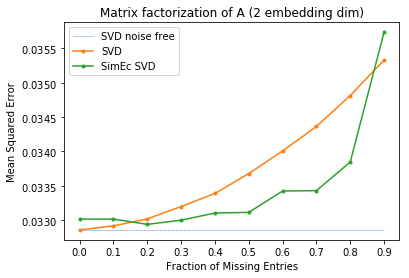

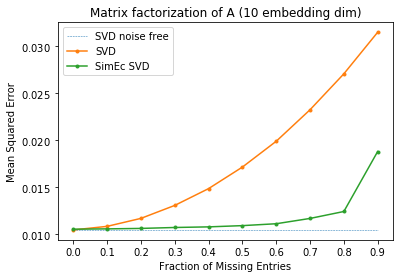

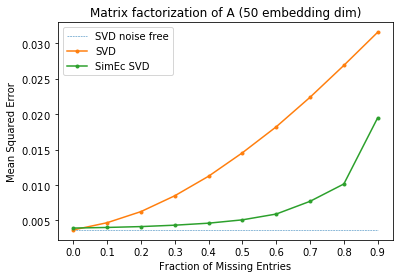

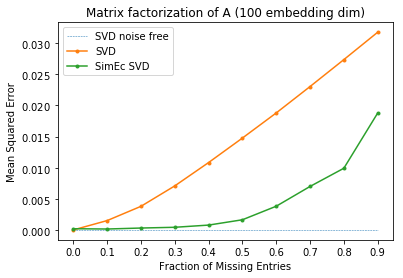

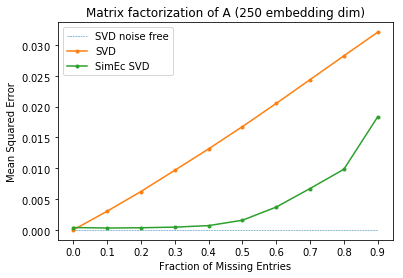

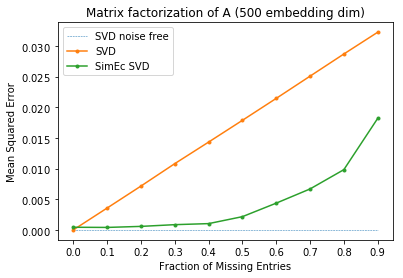

In [10]:
X = np.eye(n_input)
missing_targets = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
e_dims =  [2, 10, 50, 100, 250, 500]
for e_dim in e_dims:
    np.random.seed(15)
    mses = []
    mses_svd = []
    mse_svd = msqe(A, np.dot(U[:,:e_dim], np.dot(S[:e_dim,:e_dim], Vh[:e_dim,:])))
    for m in missing_targets:
        print m
        A_noisy = A.copy()
        A_noisy[np.random.rand(*A_noisy.shape)<=m] = -100
        model = SimilarityEncoder(n_input, e_dim, n_output, mask_value=-100, l2_reg_emb=0.00001, 
                                  l2_reg_out=0. if m < 0.7 else 0.00001, opt=keras.optimizers.Adamax(lr=0.025 if e_dim < 50 else 0.01))
        model.fit(X, A_noisy, epochs=60)
        mse = msqe(A, model.predict(X))
        mses.append(mse)
        A_noisy[A_noisy == -100] = np.mean(A)
        U_n, s_n, Vh_n = np.linalg.svd(A_noisy, full_matrices=True)
        S_n = np.zeros((n_input, n_output))
        S_n[:n_input, :n_input] = np.diag(s_n)
        mses_svd.append(msqe(A, np.dot(U_n[:,:e_dim], np.dot(S_n[:e_dim,:e_dim], Vh_n[:e_dim,:]))))
    print mses
    plt.figure();
    plt.plot([0, missing_targets[-1]], [mse_svd, mse_svd], '--', linewidth=0.5, label='SVD noise free');
    plt.plot(missing_targets, mses_svd, '-o', markersize=3, label='SVD');
    plt.plot(missing_targets, mses, '-o', markersize=3, label='SimEc SVD');
    plt.legend(loc=0);
    plt.title('Matrix factorization of A (%i embedding dim)' % e_dim);
    plt.xticks(missing_targets, missing_targets);
    plt.xlabel('Fraction of Missing Entries');
    plt.ylabel('Mean Squared Error');

### Eigendecomposition of a square symmetric matrix

In [11]:
# get 2 square symmetric matrices as AA^T and A^TA
S1 = np.dot(A, A.T)
S2 = np.dot(A.T, A)
# make sure their range of values is still sort of reasonable (for >100 we should probably rescale)
np.max(S1), np.min(S1), np.max(S2), np.min(S2)

(59.695435723025966,
 -27.98543792640249,
 41.138757582464692,
 -20.548242102046601)

In [12]:
# the corresponding SVD eigenvalues and -vectors should work here as well
for e_dim in [2, 10, 25, 50, 75, 100, 250, 400, 500]:
    print "mse with %3i e_dim: %11.8f" % (e_dim, msqe(S1, np.dot(U[:,:e_dim], np.dot(S[:e_dim,:e_dim]**2, U.T[:e_dim,:]))))
S_out = np.zeros((n_output, n_output))
S_out[:n_input, :n_input] = S[:n_input, :n_input]
for e_dim in [2, 10, 25, 50, 75, 100, 250, 500, 700]:
    print "mse with %3i e_dim: %11.8f" % (e_dim, msqe(S2, np.dot(Vh.T[:,:e_dim], np.dot(S_out[:e_dim,:e_dim]**2, Vh[:e_dim,:]))))

mse with   2 e_dim: 31.81649696
mse with  10 e_dim:  1.06578559
mse with  25 e_dim:  0.22234735
mse with  50 e_dim:  0.12643778
mse with  75 e_dim:  0.05437228
mse with 100 e_dim:  0.00001633
mse with 250 e_dim:  0.00000222
mse with 400 e_dim:  0.00000009
mse with 500 e_dim:  0.00000000
mse with   2 e_dim: 16.23290661
mse with  10 e_dim:  0.54376816
mse with  25 e_dim:  0.11344252
mse with  50 e_dim:  0.06450907
mse with  75 e_dim:  0.02774096
mse with 100 e_dim:  0.00000833
mse with 250 e_dim:  0.00000113
mse with 500 e_dim:  0.00000000
mse with 700 e_dim:  0.00000000


In [13]:
# factorize the similarity matrix S1 with a simec
X = np.eye(n_input)
mses1 = []
mses2 = []
e_dims =  [2,   10,  25,  50,  75,  100,  250,  400,  500,  750,  1000]
l_rates = [0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01]
for i, e_dim in enumerate(e_dims):
    model = SimilarityEncoder(n_input, e_dim, S1.shape[1], s_ll_reg=0.5, S_ll=S1, opt=keras.optimizers.Adamax(lr=l_rates[i]))
    model.fit(X, S1, epochs=100)
    mse = msqe(S1, model.predict(X))
    mses1.append(mse)
    print "mse with %4i e_dim: %11.8f" % (e_dim, mse)
    # scalar product of emedding should also approximate S1
    Y = model.transform(X)
    mse = msqe(S1, np.dot(Y, Y.T))
    mses2.append(mse)
    print "mse with %4i e_dim: %11.8f" % (e_dim, mse)
for i, e_dim in enumerate(e_dims):
    print "mse with %4i e_dim: %11.8f (%11.8f)" % (e_dim, mses1[i], mses2[i])

Epoch 1/100
500/500 [==============================] - 1s 3ms/step - loss: 61.4501
Epoch 2/100
500/500 [==============================] - 0s 104us/step - loss: 54.9605
Epoch 3/100
500/500 [==============================] - 0s 105us/step - loss: 52.7445
Epoch 4/100
500/500 [==============================] - 0s 108us/step - loss: 51.3920
Epoch 5/100
500/500 [==============================] - 0s 104us/step - loss: 50.7416
Epoch 6/100
500/500 [==============================] - 0s 99us/step - loss: 50.3321
Epoch 7/100
500/500 [==============================] - 0s 86us/step - loss: 49.9934
Epoch 8/100
500/500 [==============================] - 0s 91us/step - loss: 49.7120
Epoch 9/100
500/500 [==============================] - 0s 91us/step - loss: 49.4830
Epoch 10/100
500/500 [==============================] - 0s 103us/step - loss: 49.2913
Epoch 11/100
500/500 [==============================] - 0s 105us/step - loss: 49.1379
Epoch 12/100
500/500 [==============================] - 0s 93us/step 

500/500 [==============================] - 0s 89us/step - loss: 47.9700
Epoch 97/100
500/500 [==============================] - 0s 88us/step - loss: 47.9699
Epoch 98/100
500/500 [==============================] - 0s 100us/step - loss: 47.9741
Epoch 99/100
500/500 [==============================] - 0s 98us/step - loss: 47.9637
Epoch 100/100
500/500 [==============================] - 0s 101us/step - loss: 47.9772
mse with    2 e_dim: 31.94546050
mse with    2 e_dim: 31.94439998
Epoch 1/100
500/500 [==============================] - 1s 3ms/step - loss: 58.1001
Epoch 2/100
500/500 [==============================] - 0s 107us/step - loss: 49.9658
Epoch 3/100
500/500 [==============================] - 0s 113us/step - loss: 42.3654
Epoch 4/100
500/500 [==============================] - 0s 109us/step - loss: 34.7491
Epoch 5/100
500/500 [==============================] - 0s 120us/step - loss: 28.6986
Epoch 6/100
500/500 [==============================] - 0s 134us/step - loss: 24.6043
Epoch 7/100

500/500 [==============================] - 0s 82us/step - loss: 1.7265
Epoch 93/100
500/500 [==============================] - 0s 88us/step - loss: 1.7273
Epoch 94/100
500/500 [==============================] - 0s 134us/step - loss: 1.7275
Epoch 95/100
500/500 [==============================] - 0s 97us/step - loss: 1.7297
Epoch 96/100
500/500 [==============================] - 0s 94us/step - loss: 1.7270
Epoch 97/100
500/500 [==============================] - 0s 93us/step - loss: 1.7286
Epoch 98/100
500/500 [==============================] - 0s 97us/step - loss: 1.7254
Epoch 99/100
500/500 [==============================] - 0s 108us/step - loss: 1.7258
Epoch 100/100
500/500 [==============================] - 0s 94us/step - loss: 1.7277
mse with   10 e_dim:  1.07358773
mse with   10 e_dim:  1.07009565
Epoch 1/100
500/500 [==============================] - 1s 3ms/step - loss: 56.0180
Epoch 2/100
500/500 [==============================] - 0s 125us/step - loss: 42.5797
Epoch 3/100
500/500 

500/500 [==============================] - 0s 94us/step - loss: 0.4987
Epoch 89/100
500/500 [==============================] - 0s 96us/step - loss: 0.4997
Epoch 90/100
500/500 [==============================] - 0s 100us/step - loss: 0.5008
Epoch 91/100
500/500 [==============================] - 0s 88us/step - loss: 0.5003
Epoch 92/100
500/500 [==============================] - 0s 102us/step - loss: 0.5004
Epoch 93/100
500/500 [==============================] - 0s 100us/step - loss: 0.5010
Epoch 94/100
500/500 [==============================] - 0s 113us/step - loss: 0.5005
Epoch 95/100
500/500 [==============================] - 0s 107us/step - loss: 0.5007
Epoch 96/100
500/500 [==============================] - 0s 101us/step - loss: 0.5002
Epoch 97/100
500/500 [==============================] - 0s 105us/step - loss: 0.5011
Epoch 98/100
500/500 [==============================] - 0s 87us/step - loss: 0.4996
Epoch 99/100
500/500 [==============================] - 0s 93us/step - loss: 0.498

500/500 [==============================] - 0s 103us/step - loss: 0.3970
Epoch 84/100
500/500 [==============================] - 0s 93us/step - loss: 0.3949
Epoch 85/100
500/500 [==============================] - 0s 104us/step - loss: 0.3943
Epoch 86/100
500/500 [==============================] - 0s 112us/step - loss: 0.3937
Epoch 87/100
500/500 [==============================] - 0s 103us/step - loss: 0.3917
Epoch 88/100
500/500 [==============================] - 0s 95us/step - loss: 0.3907
Epoch 89/100
500/500 [==============================] - 0s 95us/step - loss: 0.3895
Epoch 90/100
500/500 [==============================] - 0s 106us/step - loss: 0.3882
Epoch 91/100
500/500 [==============================] - 0s 101us/step - loss: 0.3870
Epoch 92/100
500/500 [==============================] - 0s 100us/step - loss: 0.3875
Epoch 93/100
500/500 [==============================] - 0s 102us/step - loss: 0.3894
Epoch 94/100
500/500 [==============================] - 0s 120us/step - loss: 0.3

500/500 [==============================] - 0s 96us/step - loss: 0.2751
Epoch 80/100
500/500 [==============================] - 0s 92us/step - loss: 0.2747
Epoch 81/100
500/500 [==============================] - 0s 108us/step - loss: 0.2734
Epoch 82/100
500/500 [==============================] - 0s 104us/step - loss: 0.2711
Epoch 83/100
500/500 [==============================] - 0s 114us/step - loss: 0.2729
Epoch 84/100
500/500 [==============================] - 0s 107us/step - loss: 0.2729
Epoch 85/100
500/500 [==============================] - 0s 103us/step - loss: 0.2736
Epoch 86/100
500/500 [==============================] - 0s 117us/step - loss: 0.2738
Epoch 87/100
500/500 [==============================] - 0s 105us/step - loss: 0.2750
Epoch 88/100
500/500 [==============================] - 0s 112us/step - loss: 0.2734
Epoch 89/100
500/500 [==============================] - 0s 101us/step - loss: 0.2734
Epoch 90/100
500/500 [==============================] - 0s 99us/step - loss: 0.2

500/500 [==============================] - 0s 134us/step - loss: 0.2499
Epoch 76/100
500/500 [==============================] - 0s 100us/step - loss: 0.2470
Epoch 77/100
500/500 [==============================] - 0s 106us/step - loss: 0.2447
Epoch 78/100
500/500 [==============================] - 0s 88us/step - loss: 0.2421
Epoch 79/100
500/500 [==============================] - 0s 97us/step - loss: 0.2397
Epoch 80/100
500/500 [==============================] - 0s 90us/step - loss: 0.2369
Epoch 81/100
500/500 [==============================] - 0s 109us/step - loss: 0.2351
Epoch 82/100
500/500 [==============================] - 0s 90us/step - loss: 0.2326
Epoch 83/100
500/500 [==============================] - 0s 95us/step - loss: 0.2300
Epoch 84/100
500/500 [==============================] - 0s 111us/step - loss: 0.2277
Epoch 85/100
500/500 [==============================] - 0s 113us/step - loss: 0.2249
Epoch 86/100
500/500 [==============================] - 0s 103us/step - loss: 0.223

500/500 [==============================] - 0s 98us/step - loss: 0.1513
Epoch 72/100
500/500 [==============================] - 0s 100us/step - loss: 0.1505
Epoch 73/100
500/500 [==============================] - 0s 109us/step - loss: 0.1498
Epoch 74/100
500/500 [==============================] - 0s 98us/step - loss: 0.1492
Epoch 75/100
500/500 [==============================] - 0s 92us/step - loss: 0.1486
Epoch 76/100
500/500 [==============================] - 0s 104us/step - loss: 0.1482
Epoch 77/100
500/500 [==============================] - 0s 124us/step - loss: 0.1476
Epoch 78/100
500/500 [==============================] - 0s 111us/step - loss: 0.1479
Epoch 79/100
500/500 [==============================] - 0s 100us/step - loss: 0.1474
Epoch 80/100
500/500 [==============================] - 0s 105us/step - loss: 0.1465
Epoch 81/100
500/500 [==============================] - 0s 100us/step - loss: 0.1466
Epoch 82/100
500/500 [==============================] - 0s 129us/step - loss: 0.1

500/500 [==============================] - 0s 120us/step - loss: 0.3289
Epoch 67/100
500/500 [==============================] - 0s 120us/step - loss: 0.3185
Epoch 68/100
500/500 [==============================] - 0s 121us/step - loss: 0.3089
Epoch 69/100
500/500 [==============================] - 0s 116us/step - loss: 0.3001
Epoch 70/100
500/500 [==============================] - 0s 125us/step - loss: 0.2917
Epoch 71/100
500/500 [==============================] - 0s 133us/step - loss: 0.2841
Epoch 72/100
500/500 [==============================] - 0s 125us/step - loss: 0.2776
Epoch 73/100
500/500 [==============================] - 0s 117us/step - loss: 0.2706
Epoch 74/100
500/500 [==============================] - 0s 108us/step - loss: 0.2647
Epoch 75/100
500/500 [==============================] - 0s 101us/step - loss: 0.2588
Epoch 76/100
500/500 [==============================] - 0s 108us/step - loss: 0.2536
Epoch 77/100
500/500 [==============================] - 0s 110us/step - loss: 

500/500 [==============================] - 0s 134us/step - loss: 0.3141
Epoch 62/100
500/500 [==============================] - 0s 128us/step - loss: 0.3039
Epoch 63/100
500/500 [==============================] - 0s 109us/step - loss: 0.2946
Epoch 64/100
500/500 [==============================] - 0s 121us/step - loss: 0.2864
Epoch 65/100
500/500 [==============================] - 0s 134us/step - loss: 0.2786
Epoch 66/100
500/500 [==============================] - 0s 128us/step - loss: 0.2709
Epoch 67/100
500/500 [==============================] - 0s 111us/step - loss: 0.2644
Epoch 68/100
500/500 [==============================] - 0s 130us/step - loss: 0.2584
Epoch 69/100
500/500 [==============================] - 0s 126us/step - loss: 0.2525
Epoch 70/100
500/500 [==============================] - 0s 130us/step - loss: 0.2471
Epoch 71/100
500/500 [==============================] - 0s 122us/step - loss: 0.2420
Epoch 72/100
500/500 [==============================] - 0s 132us/step - loss: 

500/500 [==============================] - 0s 145us/step - loss: 0.2695
Epoch 57/100
500/500 [==============================] - 0s 127us/step - loss: 0.2623
Epoch 58/100
500/500 [==============================] - 0s 129us/step - loss: 0.2552
Epoch 59/100
500/500 [==============================] - 0s 137us/step - loss: 0.2491
Epoch 60/100
500/500 [==============================] - 0s 136us/step - loss: 0.2434
Epoch 61/100
500/500 [==============================] - 0s 136us/step - loss: 0.2378
Epoch 62/100
500/500 [==============================] - 0s 126us/step - loss: 0.2326
Epoch 63/100
500/500 [==============================] - 0s 145us/step - loss: 0.2283
Epoch 64/100
500/500 [==============================] - 0s 136us/step - loss: 0.2240
Epoch 65/100
500/500 [==============================] - 0s 125us/step - loss: 0.2199
Epoch 66/100
500/500 [==============================] - 0s 130us/step - loss: 0.2162
Epoch 67/100
500/500 [==============================] - 0s 138us/step - loss: 

500/500 [==============================] - 0s 159us/step - loss: 0.2609
Epoch 52/100
500/500 [==============================] - 0s 144us/step - loss: 0.2538
Epoch 53/100
500/500 [==============================] - 0s 135us/step - loss: 0.2473
Epoch 54/100
500/500 [==============================] - 0s 130us/step - loss: 0.2414
Epoch 55/100
500/500 [==============================] - 0s 147us/step - loss: 0.2359
Epoch 56/100
500/500 [==============================] - 0s 135us/step - loss: 0.2310
Epoch 57/100
500/500 [==============================] - 0s 139us/step - loss: 0.2262
Epoch 58/100
500/500 [==============================] - 0s 135us/step - loss: 0.2217
Epoch 59/100
500/500 [==============================] - 0s 144us/step - loss: 0.2177
Epoch 60/100
500/500 [==============================] - 0s 142us/step - loss: 0.2139 0s - loss: 0.213
Epoch 61/100
500/500 [==============================] - 0s 141us/step - loss: 0.2104
Epoch 62/100
500/500 [==============================] - 0s 13

In [14]:
# factorize the similarity matrix S2 with a simec
X = np.eye(n_output)
mses1 = []
mses2 = []
e_dims =  [2,   10,  25,  50,  75,  100,  250,  400,  500,  750,  1000]
l_rates = [0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01]
for i, e_dim in enumerate(e_dims):
    model = SimilarityEncoder(n_output, e_dim, S2.shape[1], s_ll_reg=0.5, S_ll=S2, opt=keras.optimizers.Adamax(lr=l_rates[i]))
    model.fit(X, S2, epochs=60)
    mse = msqe(S2, model.predict(X))
    mses1.append(mse)
    print "mse with %4i e_dim: %11.8f" % (e_dim, mse)
    # scalar product of emedding should also approximate S1
    Y = model.transform(X)
    mse = msqe(S2, np.dot(Y, Y.T))
    mses2.append(mse)
    print "mse with %4i e_dim: %11.8f" % (e_dim, mse)
for i, e_dim in enumerate(e_dims):
    print "mse with %4i e_dim: %11.8f (%11.8f)" % (e_dim, mses1[i], mses2[i])

Epoch 1/60
700/700 [==============================] - 2s 2ms/step - loss: 30.1997
Epoch 2/60
700/700 [==============================] - 0s 97us/step - loss: 27.6026
Epoch 3/60
700/700 [==============================] - 0s 99us/step - loss: 26.6547
Epoch 4/60
700/700 [==============================] - 0s 111us/step - loss: 26.0480
Epoch 5/60
700/700 [==============================] - 0s 99us/step - loss: 25.7393
Epoch 6/60
700/700 [==============================] - 0s 98us/step - loss: 25.5138
Epoch 7/60
700/700 [==============================] - 0s 100us/step - loss: 25.3494
Epoch 8/60
700/700 [==============================] - 0s 85us/step - loss: 25.2104
Epoch 9/60
700/700 [==============================] - 0s 99us/step - loss: 25.1006
Epoch 10/60
700/700 [==============================] - 0s 92us/step - loss: 24.9894
Epoch 11/60
700/700 [==============================] - 0s 97us/step - loss: 24.9084
Epoch 12/60
700/700 [==============================] - 0s 99us/step - loss: 24.8457


700/700 [==============================] - 0s 133us/step - loss: 1.0395
Epoch 38/60
700/700 [==============================] - 0s 119us/step - loss: 1.0272
Epoch 39/60
700/700 [==============================] - 0s 128us/step - loss: 1.0093
Epoch 40/60
700/700 [==============================] - 0s 123us/step - loss: 1.0013
Epoch 41/60
700/700 [==============================] - 0s 114us/step - loss: 0.9898
Epoch 42/60
700/700 [==============================] - 0s 112us/step - loss: 0.9796
Epoch 43/60
700/700 [==============================] - 0s 111us/step - loss: 0.9712
Epoch 44/60
700/700 [==============================] - 0s 102us/step - loss: 0.9650
Epoch 45/60
700/700 [==============================] - 0s 96us/step - loss: 0.9625
Epoch 46/60
700/700 [==============================] - 0s 97us/step - loss: 0.9550
Epoch 47/60
700/700 [==============================] - 0s 100us/step - loss: 0.9521
Epoch 48/60
700/700 [==============================] - 0s 112us/step - loss: 0.9467
Epoch 

700/700 [==============================] - 0s 123us/step - loss: 0.6484
Epoch 14/60
700/700 [==============================] - 0s 90us/step - loss: 0.5746
Epoch 15/60
700/700 [==============================] - 0s 105us/step - loss: 0.5195
Epoch 16/60
700/700 [==============================] - 0s 109us/step - loss: 0.4754
Epoch 17/60
700/700 [==============================] - 0s 115us/step - loss: 0.4432
Epoch 18/60
700/700 [==============================] - 0s 97us/step - loss: 0.4182
Epoch 19/60
700/700 [==============================] - 0s 95us/step - loss: 0.3974
Epoch 20/60
700/700 [==============================] - 0s 125us/step - loss: 0.3806
Epoch 21/60
700/700 [==============================] - 0s 131us/step - loss: 0.3674
Epoch 22/60
700/700 [==============================] - 0s 119us/step - loss: 0.3564
Epoch 23/60
700/700 [==============================] - 0s 121us/step - loss: 0.3468
Epoch 24/60
700/700 [==============================] - 0s 121us/step - loss: 0.3396
Epoch 2

700/700 [==============================] - 0s 111us/step - loss: 0.2230
Epoch 51/60
700/700 [==============================] - 0s 112us/step - loss: 0.2232
Epoch 52/60
700/700 [==============================] - 0s 113us/step - loss: 0.2233
Epoch 53/60
700/700 [==============================] - 0s 116us/step - loss: 0.2232
Epoch 54/60
700/700 [==============================] - 0s 101us/step - loss: 0.2239
Epoch 55/60
700/700 [==============================] - 0s 109us/step - loss: 0.2261
Epoch 56/60
700/700 [==============================] - 0s 116us/step - loss: 0.2276
Epoch 57/60
700/700 [==============================] - 0s 118us/step - loss: 0.2286
Epoch 58/60
700/700 [==============================] - 0s 113us/step - loss: 0.2288
Epoch 59/60
700/700 [==============================] - 0s 104us/step - loss: 0.2288
Epoch 60/60
700/700 [==============================] - 0s 115us/step - loss: 0.2331
mse with   75 e_dim:  0.08197645
mse with   75 e_dim:  0.13223260
Epoch 1/60
700/700 [==

700/700 [==============================] - 0s 112us/step - loss: 0.1955
Epoch 27/60
700/700 [==============================] - 0s 106us/step - loss: 0.1914
Epoch 28/60
700/700 [==============================] - 0s 110us/step - loss: 0.1875
Epoch 29/60
700/700 [==============================] - 0s 110us/step - loss: 0.1841
Epoch 30/60
700/700 [==============================] - 0s 110us/step - loss: 0.1810
Epoch 31/60
700/700 [==============================] - 0s 108us/step - loss: 0.1780
Epoch 32/60
700/700 [==============================] - 0s 123us/step - loss: 0.1753
Epoch 33/60
700/700 [==============================] - 0s 118us/step - loss: 0.1727
Epoch 34/60
700/700 [==============================] - 0s 121us/step - loss: 0.1702
Epoch 35/60
700/700 [==============================] - 0s 109us/step - loss: 0.1678
Epoch 36/60
700/700 [==============================] - 0s 121us/step - loss: 0.1657
Epoch 37/60
700/700 [==============================] - 0s 116us/step - loss: 0.1638
Epoc

700/700 [==============================] - 0s 120us/step - loss: 22.9541
Epoch 3/60
700/700 [==============================] - 0s 140us/step - loss: 16.5607
Epoch 4/60
700/700 [==============================] - 0s 139us/step - loss: 14.3005
Epoch 5/60
700/700 [==============================] - 0s 136us/step - loss: 12.7524
Epoch 6/60
700/700 [==============================] - 0s 133us/step - loss: 11.3293
Epoch 7/60
700/700 [==============================] - 0s 131us/step - loss: 10.0126
Epoch 8/60
700/700 [==============================] - 0s 128us/step - loss: 8.8044
Epoch 9/60
700/700 [==============================] - 0s 136us/step - loss: 7.7402
Epoch 10/60
700/700 [==============================] - 0s 138us/step - loss: 6.7688
Epoch 11/60
700/700 [==============================] - 0s 127us/step - loss: 5.9219
Epoch 12/60
700/700 [==============================] - 0s 136us/step - loss: 5.2193
Epoch 13/60
700/700 [==============================] - 0s 125us/step - loss: 4.5674
Epoch

700/700 [==============================] - 0s 151us/step - loss: 0.2477
Epoch 39/60
700/700 [==============================] - 0s 150us/step - loss: 0.2382
Epoch 40/60
700/700 [==============================] - 0s 152us/step - loss: 0.2294
Epoch 41/60
700/700 [==============================] - 0s 147us/step - loss: 0.2222
Epoch 42/60
700/700 [==============================] - 0s 151us/step - loss: 0.2154
Epoch 43/60
700/700 [==============================] - 0s 149us/step - loss: 0.2095
Epoch 44/60
700/700 [==============================] - 0s 141us/step - loss: 0.2043
Epoch 45/60
700/700 [==============================] - 0s 158us/step - loss: 0.1996
Epoch 46/60
700/700 [==============================] - 0s 143us/step - loss: 0.1955
Epoch 47/60
700/700 [==============================] - 0s 143us/step - loss: 0.1918
Epoch 48/60
700/700 [==============================] - 0s 150us/step - loss: 0.1885
Epoch 49/60
700/700 [==============================] - 0s 154us/step - loss: 0.1854
Epoc